In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from spikenet.network import Network
from spikenet.image_to_spike_convertor import ImageToSpikeConvertor

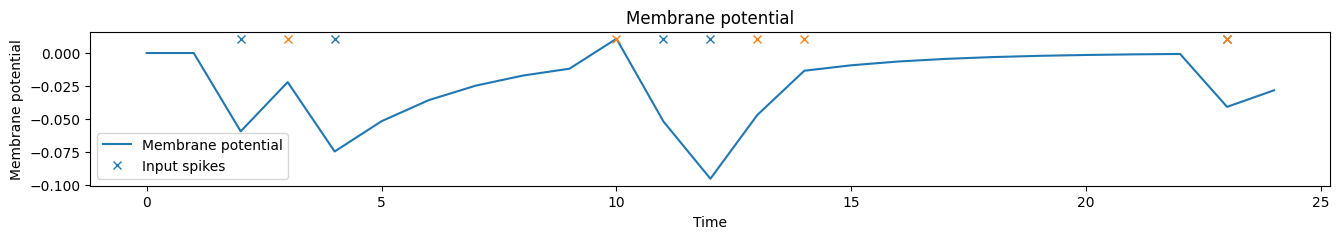

In [59]:
from spikenet.layers.spiking_dense import SpikingDenseLayer

neuron = SpikingDenseLayer(in_features=2, out_features=1)
neuron.initialize_parameters()

input_spikes = (torch.rand(1, 25, 2) > 0.8).float()
neuron(input_spikes)

fig, ax = plt.subplots(1, 1, figsize=(16, 2))
neuron.plot_mem(ax)
for t in range(25):
    for n in range(2):
        if input_spikes[0, t, n]:
            ax.plot(t, input_spikes[0, t, n] * float(neuron.mem_rec.max()), "x", color=f"C{n}")
plt.legend(["Membrane potential", "Input spikes"])
plt.show()

In [66]:
class MyData(ImageToSpikeConvertor):
    RESIZE_SIZE = (16, 16)

    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            train_data=torchvision.datasets.MNIST(
                root="./data",
                train=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize(self.RESIZE_SIZE),
                        transforms.ToTensor(),
                    ]
                ),
                download=True,
            ),
            test_data=torchvision.datasets.MNIST(
                root="./data",
                train=False,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize(self.RESIZE_SIZE),
                        transforms.ToTensor(),
                    ]
                ),
            ),
            **kwargs,
        )

    def x_transform(self, x):
        x = super().x_transform(x)
        res = x.reshape(-1, self.time_scale, self.RESIZE_SIZE[0] * self.RESIZE_SIZE[1])
        return res


data = MyData()
data.describe()

shape:
  - x: torch.Size([16, 256])
  - y: torch.Size([])
  - batch_size: 128


This is the representation of the commulation of spikes in each pixel

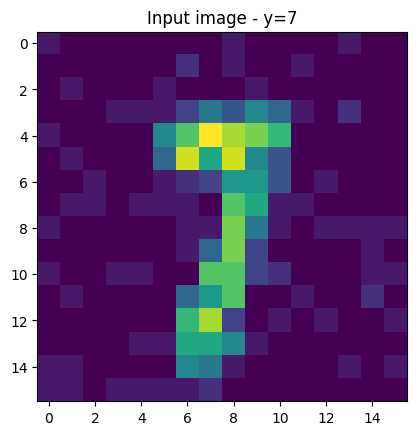

In [68]:
test_data = data.sample()
data_x, data_y = test_data

img = data_x.reshape([data.time_scale, *data.RESIZE_SIZE])
img = img.sum(0)
plt.imshow(img)
plt.title(f"Input image - y={data_y}")
plt.show()

Spike in time:

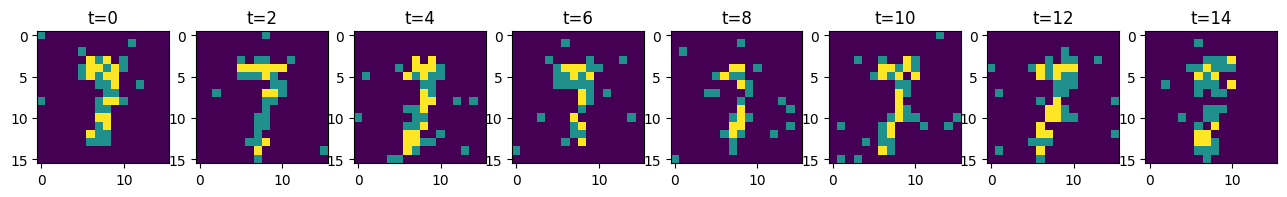

In [69]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
imgs = data_x.reshape([data.time_scale, *data.RESIZE_SIZE])

T = 2
for t in range(0, data.time_scale, T):
    img = imgs[t: t + T].sum(0)
    ax = axs[t // T]
    ax.imshow(img)
    ax.set_title(f"t={t}")

plt.show()

In [62]:
input_size = data.RESIZE_SIZE[0] * data.RESIZE_SIZE[1]
net = (
    Network()
    .add_layer(SpikingDenseLayer, 50, in_features=input_size)
    .add_layer(SpikingDenseLayer, 10)
).build()
net.summary()

Network: Network
--------------------------------------------------
0) 24_SpikingDenseLayer(50)
1) 25_SpikingDenseLayer(10)


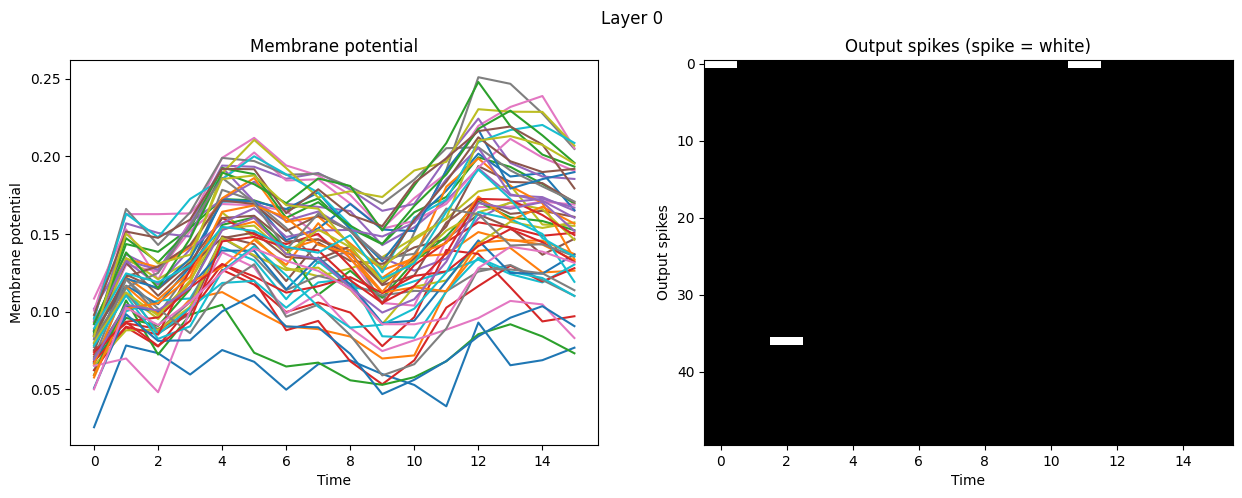

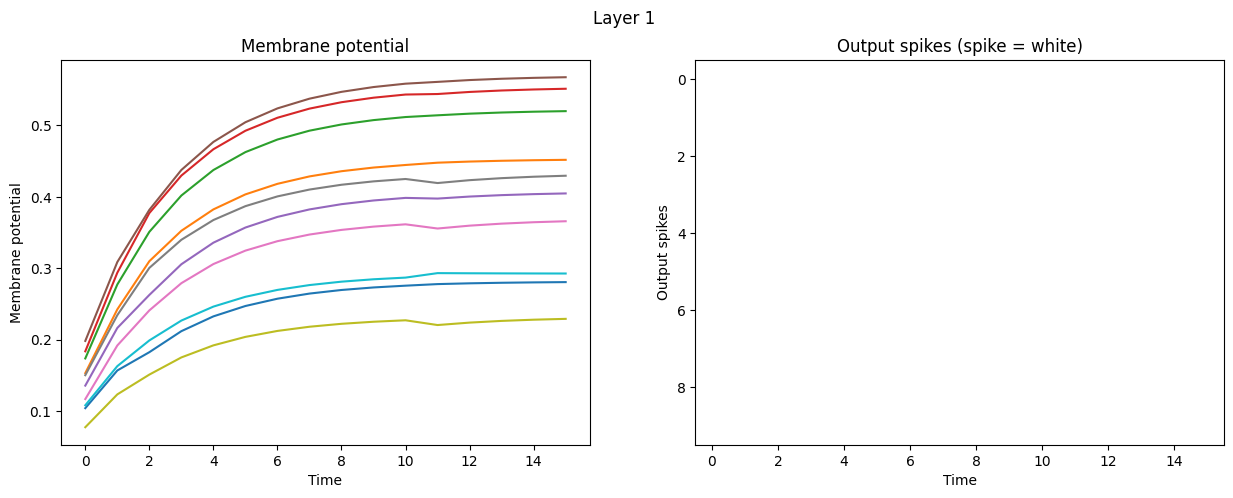

In [74]:
net.forward(data_x.reshape(1, -1, input_size))
net.plot_activity()